In [32]:
import pandas as pd
import numpy as np

data = pd.read_csv("data_cleaning/final-cleaned-charging-records.csv")
data.head()

,UserID,ChargerCompany,ChargerType,StartHour,StartDayOfWeek,IsWeekend,Duration,Demand
0,95,1,0,22,4,0,251,29.7
1,95,1,0,4,5,1,243,28.6
2,95,1,0,22,5,1,246,29.1
3,95,1,0,4,6,1,97,11.4
4,95,1,0,13,6,1,80,9.4


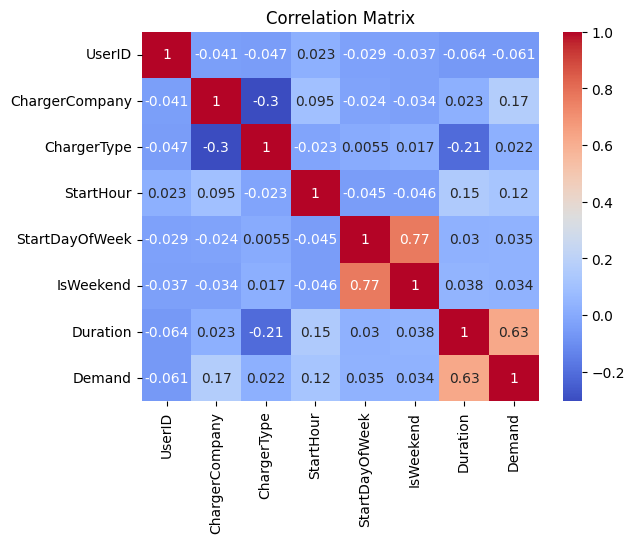

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [34]:
print(f"Total Records: {len(data)}")

Total Records: 11463


In [35]:
sequence_length = 5

In [36]:
def sequence_generator(data, sequence_length):
    data_as_np = data.to_numpy()
    x = []
    y = []
    for i in range(len(data_as_np) - sequence_length):
        if data_as_np[i][0] == data_as_np[i+sequence_length][0]:
            row = [data_as_np[r][1:] for r in range(i, i+sequence_length)]
            x.append(row)
            label = [data_as_np[i+sequence_length][-2], data_as_np[i+sequence_length][-1]]
            y.append(label)
    return np.array(x), np.array(y)

In [37]:
x, y = sequence_generator(data, sequence_length)

In [38]:
train_size = int(len(x) * 0.7)
val_size = int(len(x) * 0.85)
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:val_size], y[train_size:val_size]
x_test, y_test = x[val_size:], y[val_size:]

print(x.shape, y.shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(10238, 5, 7) (10238, 2) (7166, 5, 7) (7166, 2) (1536, 5, 7) (1536, 2) (1536, 5, 7) (1536, 2)


In [39]:
from sklearn.preprocessing import MinMaxScaler
from joblib import dump

scalar_x = MinMaxScaler()
scalar_y = MinMaxScaler()

x_train_scaled = scalar_x.fit_transform(x_train.reshape(-1, x_train.shape[-1]))
x_val_scaled = scalar_x.transform(x_val.reshape(-1, x_val.shape[-1]))
x_test_scaled = scalar_x.transform(x_test.reshape(-1, x_test.shape[-1]))

x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_val_scaled = x_val_scaled.reshape(x_val.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

y_train_scaled = scalar_y.fit_transform(y_train)
y_val_scaled = scalar_y.transform(y_val)
y_test_scaled = scalar_y.transform(y_test)

dump(scalar_x, 'archive/x_scalar.save')
dump(scalar_y, 'archive/y_scalar.save')

print(x_train_scaled.shape, y_train_scaled.shape, x_val_scaled.shape, y_val_scaled.shape, x_test_scaled.shape, y_test_scaled.shape)

(7166, 5, 7) (7166, 2) (1536, 5, 7) (1536, 2) (1536, 5, 7) (1536, 2)


In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer

model = Sequential()
model.add(InputLayer((sequence_length, len(x[0][0]))))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(8, activation="relu"))
model.add(Dense(2))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 32)          │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,490 (119.10 KB)

 Trainable params: 30,490 (119.10 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
model.fit(x_train_scaled, y_train_scaled, validation_data=(x_val_scaled, y_val_scaled), epochs=10)

Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0689 - root_mean_squared_error: 0.2614 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1847
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0227 - root_mean_squared_error: 0.1506 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1580
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1408
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1397
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1392
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 13m

In [42]:
import matplotlib.pyplot as plt

def eval_n_plot(x_data_scaled, y_data_scaled, model, is_train_data=False):
    loss, rmse = model.evaluate(x_data_scaled, y_data_scaled)
    print(f"Loss: {loss}\tRMSE: {rmse}")
    scaled_pred = model.predict(x_data_scaled)
    y_pred = scalar_y.inverse_transform(scaled_pred)
    y_data = scalar_y.inverse_transform(y_data_scaled)
    plt.figure(figsize=(10, 6))
    plt.plot(y_data, label=['Actual Duration', 'Actual Demand'])
    plt.plot(y_pred, label=['Predicted Duration', 'Predicted Demand'])
    if is_train_data:
        plt.title('Actual vs Predicted (train data)')
    else:
        plt.title('Actual vs Predicted (test data)')
    plt.legend()
    plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516
Loss: 0.022974269464612007	RMSE: 0.15157264471054077
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


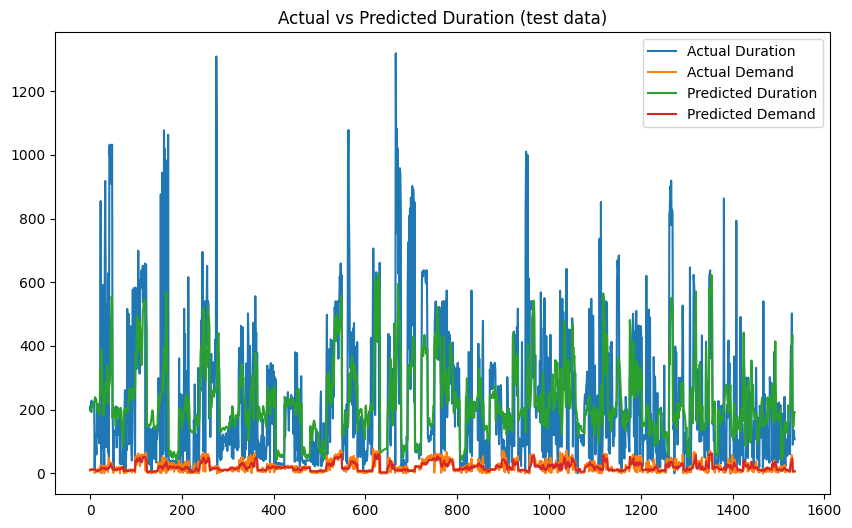

In [43]:
eval_n_plot(x_test_scaled, y_test_scaled, model)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148 - root_mean_squared_error: 0.1210
Loss: 0.013414447195827961	RMSE: 0.1158207580447197
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


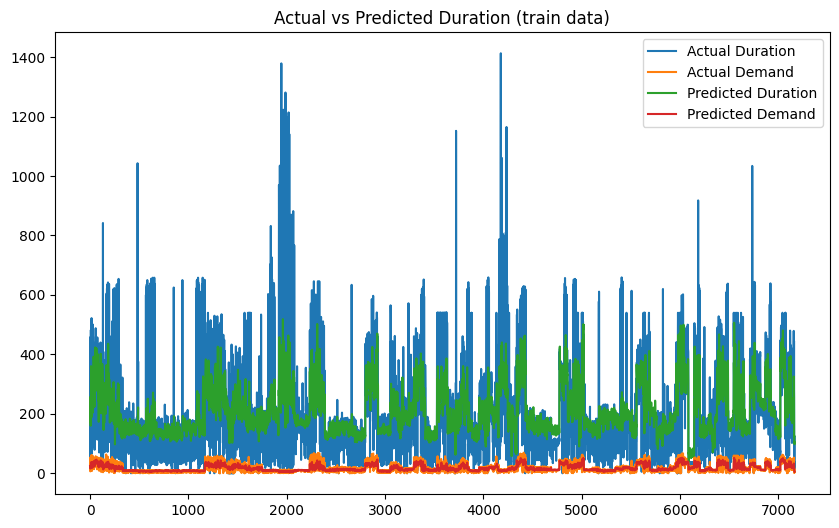

In [44]:
eval_n_plot(x_train_scaled, y_train_scaled, model, is_train_data=True)

In [45]:
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()
    model.add(InputLayer((sequence_length, len(x[0][0]))))
    model.add(LSTM(hp.Int('units_1', min_value=32, max_value=256, step=32), return_sequences=True))
    model.add(LSTM(hp.Int('units_2', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', min_value=8, max_value=128, step=8), activation='relu'))
    model.add(Dense(2))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001])),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])
    return model

tuner = RandomSearch(build_model,
                     objective='val_loss',
                     max_trials=20,
                     executions_per_trial=3,
                     directory='hyperparam_tuning',
                     project_name='lstm_tuning')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train_scaled,
             y_train_scaled,
             epochs=50,
             validation_data=(x_val_scaled, y_val_scaled),
             callbacks=[early_stop])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Reloading Tuner from hyperparam_tuning/lstm_tuning/tuner0.json


/home/farhaan/miniconda3/envs/py310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 192)         │       153,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,530 (1.26 MB)

 Trainable params: 330,530 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0218 - root_mean_squared_error: 0.1477
Loss: 0.021680599078536034	RMSE: 0.14724333584308624
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


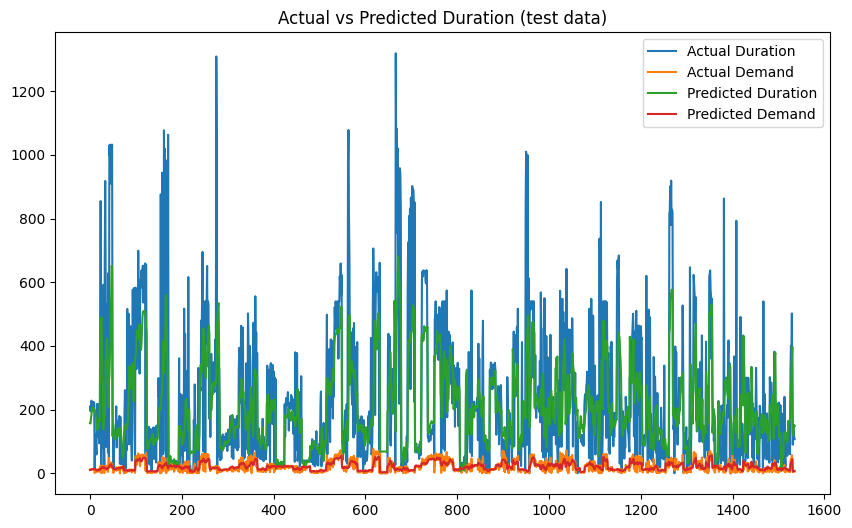

In [46]:
eval_n_plot(x_test_scaled, y_test_scaled, best_model)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144 - root_mean_squared_error: 0.1194
Loss: 0.012986652553081512	RMSE: 0.11395899206399918
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


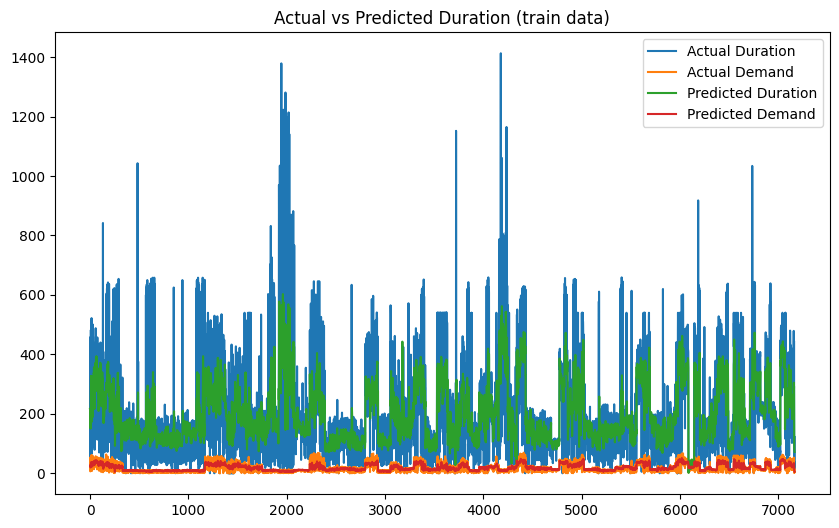

In [47]:
eval_n_plot(x_train_scaled, y_train_scaled, best_model, is_train_data=True)

In [48]:
best_model.save("archive/best_lstm_model.keras")